
# Measure fluorescence intensity at the nuclear envelope

This example reproduces a well-established workflow in bioimage data analysis
for measuring the fluorescence intensity localized to the nuclear envelope, in
a time sequence of cell images (each with two channels and two spatial
dimensions) which shows a process of protein re-localization from the
cytoplasmic area to the nuclear envelope. This biological application was
first presented by Andrea Boni and collaborators in [1]_; it was used in a
textbook by Kota Miura [2]_ as well as in other works ([3]_, [4]_).
In other words, we port this workflow from ImageJ Macro to Python with
scikit-image.

.. [1] Boni A, Politi AZ, Strnad P, Xiang W, Hossain MJ, Ellenberg J (2015)
       "Live imaging and modeling of inner nuclear membrane targeting reveals
       its molecular requirements in mammalian cells" J Cell Biol
       209(5):705–720. ISSN: 0021-9525.
       :DOI:`10.1083/jcb.201409133`
.. [2] Miura K (2020) "Measurements of Intensity Dynamics at the Periphery of
       the Nucleus" in: Miura K, Sladoje N (eds) Bioimage Data Analysis
       Workflows. Learning Materials in Biosciences. Springer, Cham.
       :DOI:`10.1007/978-3-030-22386-1_2`
.. [3] Klemm A (2020) "ImageJ/Fiji Macro Language" NEUBIAS Academy Online
       Course: https://www.youtube.com/watch?v=o8tfkdcd3DA
.. [4] Vorkel D and Haase R (2020) "GPU-accelerating ImageJ Macro image
       processing workflows using CLIJ" https://arxiv.org/abs/2008.11799


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.io
import plotly.express as px
from scipy import ndimage as ndi

from skimage import (
    filters, measure, morphology, segmentation
)
from skimage.data import protein_transport

We start with a single cell/nucleus to construct the workflow.



In [2]:
image_sequence = protein_transport()

print(f'shape: {image_sequence.shape}')

shape: (15, 2, 180, 183)


The dataset is a 2D image stack with 15 frames (time points) and 2 channels.



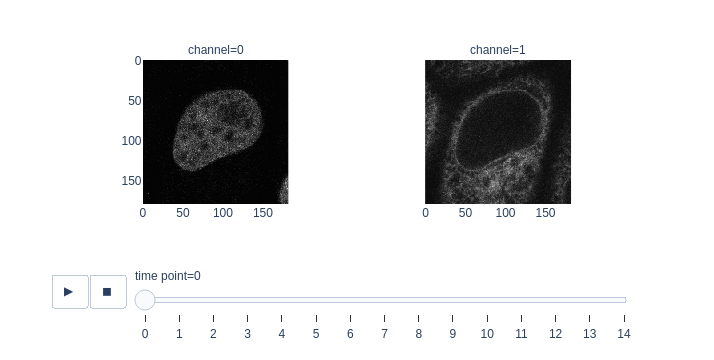

In [3]:
vmin, vmax = 0, image_sequence.max()

fig = px.imshow(
    image_sequence,
    facet_col=1,
    animation_frame=0,
    zmin=vmin,
    zmax=vmax,
    binary_string=True,
    labels={'animation_frame': 'time point', 'facet_col': 'channel'}
)
plotly.io.show(fig)

To begin with, let us consider the first channel of the first image (step
``a)`` in the figure below).



In [4]:
image_t_0_channel_0 = image_sequence[0, 0, :, :]

## Segment the nucleus rim
Let us apply a Gaussian low-pass filter to this image in order to smooth it
(step ``b)``).
Next, we segment the nuclei, finding the threshold between the background
and foreground with Otsu's method: We get a binary image (step ``c)``). We
then fill the holes in the objects (step ``c-1)``).



In [5]:
smooth = filters.gaussian(image_t_0_channel_0, sigma=1.5)

thresh_value = filters.threshold_otsu(smooth)
thresh = smooth > thresh_value

fill = ndi.binary_fill_holes(thresh)

Following the original workflow, let us remove objects which touch the image
border (step ``c-2)``). Here, we can see that part of another nucleus was
touching the bottom right-hand corner.



In [6]:
clear = segmentation.clear_border(fill)
clear.dtype

dtype('bool')

We compute both the morphological dilation of this binary image
(step ``d)``) and its morphological erosion (step ``e)``).



In [7]:
dilate = morphology.binary_dilation(clear)

erode = morphology.binary_erosion(clear)

Finally, we subtract the eroded from the dilated to get the nucleus rim
(step ``f)``). This is equivalent to selecting the pixels which are in
``dilate``, but not in ``erode``:



In [8]:
mask = np.logical_and(dilate, ~erode)

Let us visualize these processing steps in a sequence of subplots.



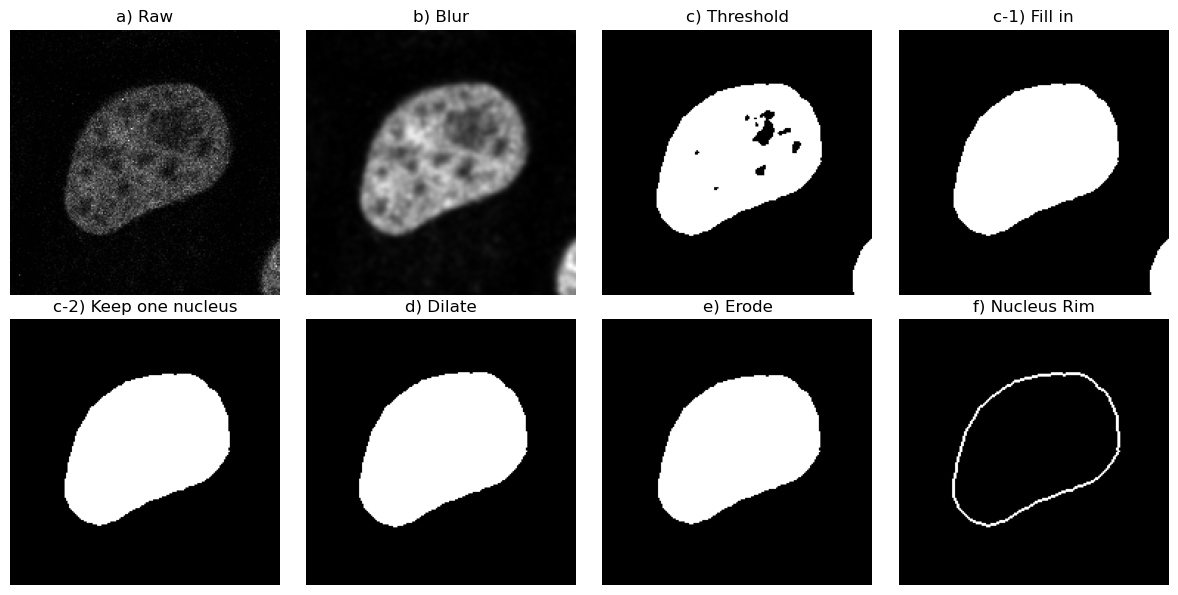

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True)

ax[0, 0].imshow(image_t_0_channel_0, cmap=plt.cm.gray)
ax[0, 0].set_title('a) Raw')

ax[0, 1].imshow(smooth, cmap=plt.cm.gray)
ax[0, 1].set_title('b) Blur')

ax[0, 2].imshow(thresh, cmap=plt.cm.gray)
ax[0, 2].set_title('c) Threshold')

ax[0, 3].imshow(fill, cmap=plt.cm.gray)
ax[0, 3].set_title('c-1) Fill in')

ax[1, 0].imshow(clear, cmap=plt.cm.gray)
ax[1, 0].set_title('c-2) Keep one nucleus')

ax[1, 1].imshow(dilate, cmap=plt.cm.gray)
ax[1, 1].set_title('d) Dilate')

ax[1, 2].imshow(erode, cmap=plt.cm.gray)
ax[1, 2].set_title('e) Erode')

ax[1, 3].imshow(mask, cmap=plt.cm.gray)
ax[1, 3].set_title('f) Nucleus Rim')

for a in ax.ravel():
    a.set_axis_off()

fig.tight_layout()

## Apply the segmented rim as a mask
Now that we have segmented the nuclear membrane in the first channel, we use
it as a mask to measure the intensity in the second channel.



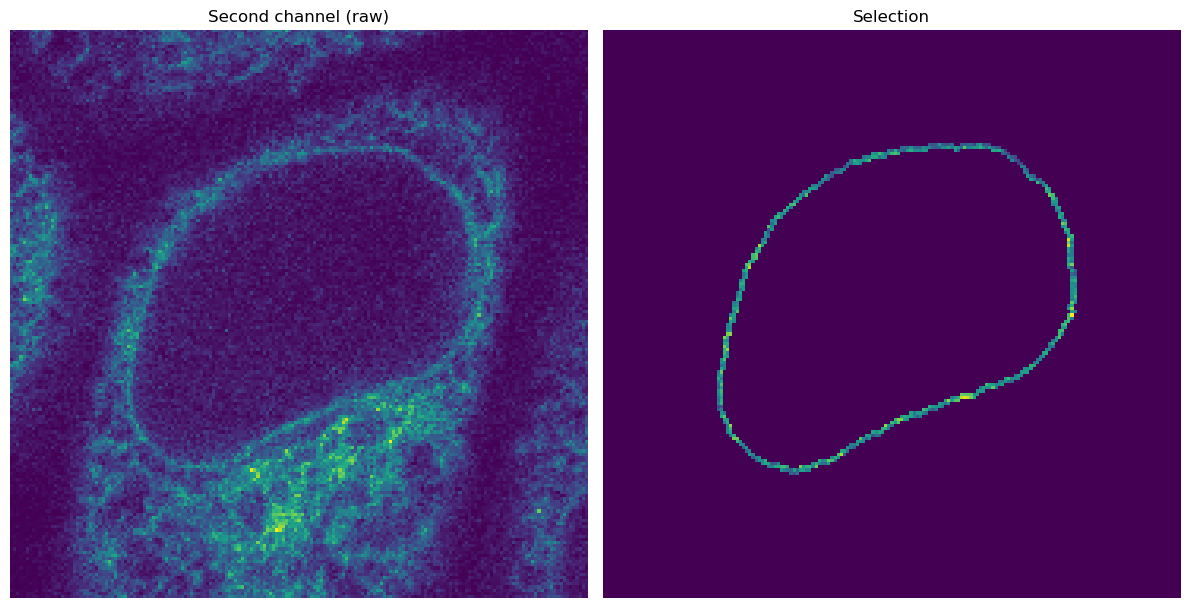

In [10]:
image_t_0_channel_1 = image_sequence[0, 1, :, :]
selection = np.where(mask, image_t_0_channel_1, 0)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax0.imshow(image_t_0_channel_1)
ax0.set_title('Second channel (raw)')
ax0.set_axis_off()

ax1.imshow(selection)
ax1.set_title('Selection')
ax1.set_axis_off()

fig.tight_layout()

## Measure the total intensity
The mean intensity is readily available as a region property in a labeled
image.



In [11]:
props = measure.regionprops_table(
    mask.astype(np.uint8),
    intensity_image=image_t_0_channel_1,
    properties=('label', 'area', 'intensity_mean')
)

We may want to check that the value for the total intensity



In [12]:
selection.sum()

28350

can be recovered from:



In [13]:
props['area'] * props['intensity_mean']

array([28350.])

## Process the entire image sequence
Instead of iterating the workflow for each time point, we process the
multidimensional dataset directly (except for the thresholding step).
Indeed, most scikit-image functions support nD images.



In [14]:
n_z = image_sequence.shape[0]  # number of frames

smooth_seq = filters.gaussian(image_sequence[:, 0, :, :], sigma=(0, 1.5, 1.5))
thresh_values = [filters.threshold_otsu(s) for s in smooth_seq[:]]
thresh_seq = [smooth_seq[k, ...] > val for k, val in enumerate(thresh_values)]

Alternatively, we could compute ``thresh_values`` without using a list
comprehension, by reshaping ``smooth_seq`` to make it 2D (where the first
dimension still corresponds to time points, but the second and last
dimension now contains all pixel values), and applying the thresholding
function on the image sequence along its second axis:

```python
thresh_values = np.apply_along_axis(filters.threshold_otsu,
                                    axis=1,
                                    arr=smooth_seq.reshape(n_z, -1))
```
We use the following flat structuring element for morphological
computations (``np.newaxis`` is used to prepend an axis of size 1 for time):



In [15]:
footprint = ndi.generate_binary_structure(2, 1)[np.newaxis, ...]
footprint

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

This way, each frame is processed independently (pixels from consecutive
frames are never spatial neighbors).



In [16]:
fill_seq = ndi.binary_fill_holes(thresh_seq, structure=footprint)

When clearing objects which touch the image border, we want to make sure
that the bottom (first) and top (last) frames are not considered as borders.
In this case, the only relevant border is the edge at the greatest (x, y)
values. This can be seen in 3D by running the following code:

```python
import plotly.graph_objects as go

sample = fill_seq
(n_Z, n_Y, n_X) = sample.shape
Z, Y, X = np.mgrid[:n_Z, :n_Y, :n_X]

fig = go.Figure(
    data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=sample.flatten(),
        opacity=0.5,
        slices_z=dict(show=True, locations=[n_z // 2])
    )
)
fig.show()
```


In [17]:
border_mask = np.ones_like(fill_seq)
border_mask[n_z // 2, -1, -1] = False
clear_seq = segmentation.clear_border(fill_seq, mask=border_mask)

dilate_seq = morphology.binary_dilation(clear_seq, footprint=footprint)
erode_seq = morphology.binary_erosion(clear_seq, footprint=footprint)
mask_sequence = np.logical_and(dilate_seq, ~erode_seq)

Let us give each mask (corresponding to each time point) a different label,
running from 1 to 15. We use ``np.min_scalar_type`` to determine the
minimum-size integer dtype needed to represent the number of time points:



In [18]:
label_dtype = np.min_scalar_type(n_z)
mask_sequence = mask_sequence.astype(label_dtype)
labels = np.arange(1, n_z + 1, dtype=label_dtype)
mask_sequence *= labels[:, np.newaxis, np.newaxis]

Let us compute the region properties of interest for all these labeled
regions.



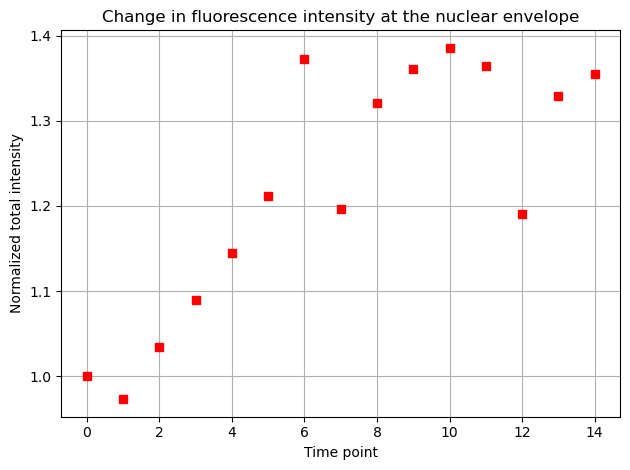

In [19]:
props = measure.regionprops_table(
    mask_sequence,
    intensity_image=image_sequence[:, 1, :, :],
    properties=('label', 'area', 'intensity_mean')
)
np.testing.assert_array_equal(props['label'], np.arange(n_z) + 1)

fluorescence_change = [props['area'][i] * props['intensity_mean'][i]
                       for i in range(n_z)]

fluorescence_change /= fluorescence_change[0]  # normalization

fig, ax = plt.subplots()
ax.plot(fluorescence_change, 'rs')
ax.grid()
ax.set_xlabel('Time point')
ax.set_ylabel('Normalized total intensity')
ax.set_title('Change in fluorescence intensity at the nuclear envelope')
fig.tight_layout()

plt.show()

Reassuringly, we find the expected result: The total fluorescence
intensity at the nuclear envelope increases 1.3-fold in the initial five
time points, and then becomes roughly constant.

